In [12]:
import json
import logging
import pandas as pd

from modeling import get_order, Runner
from plotnine import *

In [2]:
from sklearn.datasets import load_wine
wine = load_wine(as_frame = True).frame
wine["target2"] = (wine.target==1).astype(int).astype(int)
wine.loc[:,"row_id"] = wine.index

with open('reg_config.json', 'r') as config_file:
    config = json.load(config_file)

## Running Locally

In [21]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
order = get_order(df = wine, config = config)

runner = Runner(workers = 4)
runner.run(order = order)

INFO:root:Order 1fab721e-00d3-446e-9623-f4ef47b7078f - started.
INFO:root:Order 1fab721e-00d3-446e-9623-f4ef47b7078f - adding result. 1 / 1 tasks completed.
INFO:root:Order 1fab721e-00d3-446e-9623-f4ef47b7078f - finished.


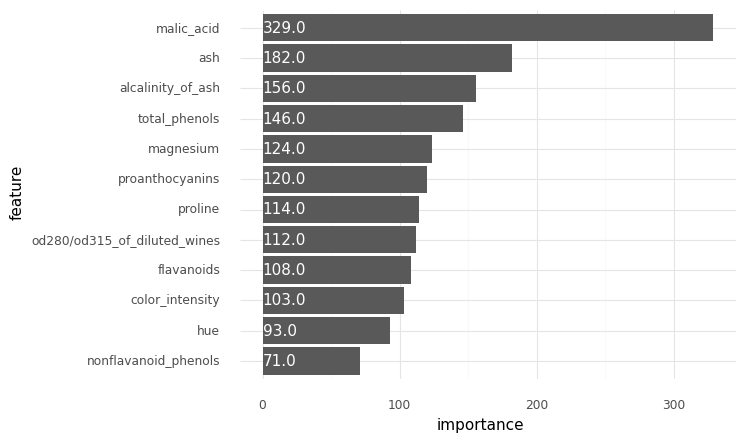

<ggplot: (8768045733976)>

In [53]:
m = order.get_results()
display = pd.DataFrame({'feature': m._model.get_fscore().keys(), 'importance': m._model.get_fscore().values()})
display = display.sort_values(by = 'importance', ascending = False).head(25).sort_values(by = 'importance', ascending = True)

(ggplot(display, aes(x = 'feature', y = 'importance'))
 + geom_bar(stat = 'identity')
 + geom_text(aes(x = 'feature', y = 0, label = 'importance'), ha = 'left', color = 'white')
 + scale_x_discrete(limits = display.feature.tolist())
 + coord_flip()
 + theme_minimal())

In [ ]:
m._model.dump_model()

In [148]:
runner._futures[0].exception()

In [97]:
evaldf = pd.DataFrame(order.get_results()['eval'])
evaldf.head()

,task_id,param_id,split_id,sklearn:mean_squared_error,sklearn:mean_absolute_error,num_boost_round,objective,eval_metric,eta,max_depth
0,3,0,1,0.565899,0.602064,1000,reg:squarederror,rmse,0.3,4
0,3,0,1,0.565899,0.602064,500,reg:squarederror,rmse,0.3,4
0,1,1,0,2.127553,1.261351,1000,reg:squarederror,rmse,0.3,6
0,1,1,0,2.127553,1.261351,500,reg:squarederror,rmse,0.3,6
0,0,0,0,1.885999,1.187294,1000,reg:squarederror,rmse,0.3,4


In [129]:
evaldf[['param_id']+list(config['model']['params'].keys())].drop_duplicates().to_csv('paramid.csv', index = False)

In [94]:
predictions = pd.DataFrame(order.get_results()['predictions'])
predictions.head()

,row_id,predictions,truth,num_boost_round,objective,eval_metric,eta,max_depth,task_id,param_id,split_id
0,89,0.990234,1,1000,reg:logistic,error,0.3,4,3,0,1
1,90,0.979258,1,1000,reg:logistic,error,0.3,4,3,0,1
2,91,0.987462,1,1000,reg:logistic,error,0.3,4,3,0,1
3,92,0.990234,1,1000,reg:logistic,error,0.3,4,3,0,1
4,93,0.962167,1,1000,reg:logistic,error,0.3,4,3,0,1


In [126]:
def make_cv_plot(df, metric_name):
    display = df.copy()
    display.loc[:, 'split_id'] = display.split_id.astype(str)
    p1 = (ggplot(display, aes(x = 'param_id', y = metric_name, color = 'split_id'))
          + geom_point(size = 5, show_legend = False)
          + theme_minimal()
          + labs(title = metric_name, x = 'Metaparameter Grouping')
          + scale_y_continuous(expand = (0.2,0))
          + scale_x_continuous(expand = (0.2,0))
         )
    return p1

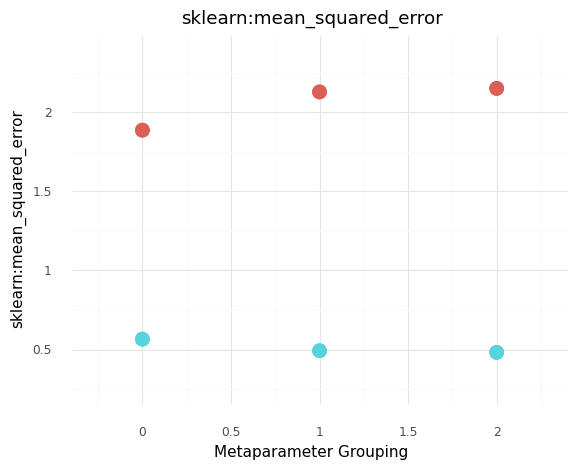

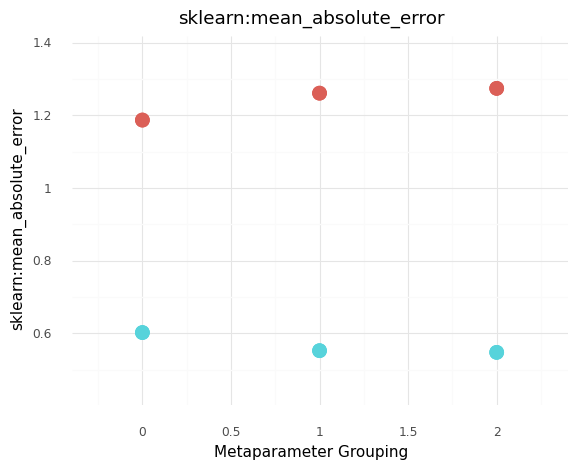

In [127]:
for metric in config['validation']['evalulation']['metrics']:
    print(make_cv_plot(df = evaldf, metric_name = metric))

## Hosted as a web service

In [9]:
import requests
request = f'http://0.0.0.0:5051/train'
r = requests.post(request,
                  json = {"config": config,
                          "df": wine.to_dict()})
job_id = r.text
print(job_id)

30afce6a-b42d-4763-b937-8017153fdf0c


In [11]:
request = f'http://0.0.0.0:5051/train/status/{job_id}'
r = requests.get(request)
r.text

'0 / 6 tasks completed.'

In [14]:
request = f'http://0.0.0.0:5051/train/jobs'
r = requests.get(request)
r.text

'30afce6a-b42d-4763-b937-8017153fdf0c'